# **Predictive models**

#### This notebook contains four models that predict whether or not a company will be bankrupt the following year according to its financial statements

#### The models implemented are:
- Random Forrest
- XGBoost
- SVM
- Neural Network

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix


from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
# Read data
df = pd.read_csv('data/american_bankruptcy.csv')

In [3]:
df['status_label'] = np.where(df['status_label'] == 'alive', 1, 0)

In [4]:
df['status_label'].value_counts()

status_label
1    73462
0     5220
Name: count, dtype: int64

#### There are 73462 instances of companies not going bankrupt and 5220 instances of companies going bankrupt. This class imbalance is addressed next.

In [5]:
# Define X and y
X=df.drop(columns=['company_name','status_label','year'])
y=df['status_label']

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666, stratify=y)

In [7]:
# Baseline prediction
y.mean()

0.9336569990595054

#### Correcting class imbalances before training a model is important to reduce bias, improve generalization, ensure accurate performance metrics, and facilitate better decision-making. To correct class imbalances, the technique employed was oversampling the underrepresented class with replacement.

In [8]:
# Correct class imbalances

# combine in a single dataframe
train_data = pd.concat([X_train, y_train], axis=1) 

# Separate the classes
class_0 = train_data[train_data[y_train.name] == 0] 
class_1 = train_data[train_data[y_train.name] == 1]

# Oversample y==0
class_0_oversampled = class_0.sample(len(class_1), replace=True, random_state=666)

# Combine balanced classes in a single dataframe
train_data_resampled = pd.concat([class_0_oversampled, class_1], axis=0)

#Shuffle the dataframe
train_data_resampled = train_data_resampled.sample(frac=1, random_state=666)

In [9]:
# Define new X and y variables after balancing classes

X_train_res = train_data_resampled.drop(y_train.name, axis=1)

y_train_res = train_data_resampled[y_train.name].astype('int64')

y_train_res.value_counts()

status_label
1    55096
0    55096
Name: count, dtype: int64

# **Prediction Models**

## Random Forest

#### A Random Forest model is an ensemble learning method that combines multiple decision trees to improve prediction accuracy and reduce overfitting. This model resulted in a Test set accuracy of 0.9407

In [10]:
p = X_train_res.shape[1]

params = {
    'max_depth': np.append(np.arange(1, 12), None),
    'max_features': np.arange(1, p + 1),
    'min_samples_leaf': np.arange(1, 31)
}

rf = RandomForestClassifier(n_estimators=100, random_state=666)
rs = RandomizedSearchCV(rf, params, n_iter=100, cv=5, scoring='accuracy', n_jobs=8, random_state=666)

In [27]:
%%time
rs.fit(X_train_res, y_train_res) # only run if necessary

CPU times: user 43.3 s, sys: 1.17 s, total: 44.5 s
Wall time: 31min 35s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=666),
                   n_iter=100, n_jobs=8,
                   param_distributions={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, None], dtype=object),
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
                   random_state=666, scoring='accuracy')

In [28]:
print("Best parameters:", rs.best_params_)
print("Best score:", rs.best_score_)

Best parameters: {'min_samples_leaf': 5, 'max_features': 8, 'max_depth': None}
Best score: 0.992159134805376


In [31]:
# Test the model
best_rf = RandomForestClassifier(**rs.best_params_, random_state=666)
best_rf.fit(X_train_res, y_train_res)

y_pred_rf = best_rf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Test set accuracy: {test_accuracy:.4f}")

Test set accuracy: 0.9407


In [15]:
# Confussion matrix

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("Confusion Matrix Random Forest:")
print(conf_matrix)

Confusion Matrix Random Forest:
[[  310   995]
 [  172 18194]]


#### **Confussion Matrix:**
- True Positives (TP): 310 - The model correctly predicted 310 instances of the positive class.
- False Positives (FP): 995 - The model incorrectly predicted 995 instances as positive, which were actually negative.
- False Negatives (FN): 172 - The model incorrectly predicted 172 instances as negative, which were actually positive.
- True Negatives (TN): 18,194 - The model correctly predicted 18,194 instances of the negative class.
- Precision (TP / (TP + FP)): 23%
- Recall (TP / (TP + FN)): 64%

## XGBoost

#### An XGBoost model is a scalable and efficient implementation of gradient boosted decision trees designed for speed and performance in machine learning tasks. This model resulted in a Test set accuracy of 0.9395

In [35]:
%%time
params = {
    'max_depth': np.arange(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=666)

# Initialize RandomizedSearchCV for hyperparameter tuning
rs_xgb = RandomizedSearchCV(xgb_clf, params, n_iter=50, cv=5, scoring='accuracy', n_jobs=8, random_state=666)

# Fit the RandomizedSearchCV object to the resampled training data
rs_xgb.fit(X_train_res, y_train_res)

/Users/juanpena/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=666, ...),
                   n_iter=50, n_jobs=8,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 0.9, 1]},
                   random_state=666, scoring='accuracy')

In [36]:
print("Best parameters:", rs_xgb.best_params_)
print("Best score:", rs_xgb.best_score_)

Best parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best score: 0.9885381840961823


In [37]:
# Use the best params to fit model and predict
best_xgb = xgb.XGBClassifier(**rs_xgb.best_params_, use_label_encoder=False, eval_metric='logloss', random_state=666)

best_xgb.fit(X_train_res, y_train_res)

y_pred_xgb = best_xgb.predict(X_test)

test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"Test set accuracy XGBoost: {test_accuracy_xgb:.4f}")

Test set accuracy XGBoost: 0.9395


In [17]:
# Confussion matrix

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print("Confusion Matrix XGBoost:")
print(conf_matrix_xgb)

Confusion Matrix XGBoost:
[[  459   846]
 [  345 18021]]


#### **Confussion Matrix:**
- True Positives (TP): 459 - The model correctly predicted 459 instances of the positive class.
- False Positives (FP): 846 - The model incorrectly predicted 846 instances as positive, which were actually negative.
- False Negatives (FN): 345 - The model incorrectly predicted 345 instances as negative, which were actually positive.
- True Negatives (TN): 18,021 - The model correctly predicted 18,021 instances of the negative class.
- Precision (TP / (TP + FP)): 35%
- Recall (TP / (TP + FN)): 57%
- Note: Overall, the XGBoost model seems to perform better than the Random Forest model in terms of identifying the positive class, as indicated by the higher number of true positives and lower number of false negatives.

## SVM

#### SVM finds the optimal hyperplane that maximizes the margin between different classes. Several versions of SVMs were tested, including different Kernel types and regularization parameters, but the results were not on par with other models.

In [41]:
%%time
pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=666))
])

param_grid_svc = [
    {
        'svc__C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
        'svc__kernel': ['rbf']  # Kernel type
    },
    {
        'svc__C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
        'svc__kernel': ['poly'],  # Kernel type
        'svc__degree': np.arange(2, 8)  # Degree of the polynomial kernel
    }
]

gs_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5, scoring='accuracy', n_jobs=8)

# Fit the GridSearchCV object to the resampled training data
gs_svc.fit(X_train_res, y_train_res)

# Print the best parameters and the corresponding score
print("Best parameters:", gs_svc.best_params_)
print("Best score:", gs_svc.best_score_)

# Use the best estimator to make predictions on the test set
y_pred_gs_svc = gs_svc.best_estimator_.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy_gs_svc = accuracy_score(y_test, y_pred_gs_svc)

print(f"Test set accuracy with GridSearchCV SVC: {test_accuracy_gs_svc:.4f}")

Best parameters: {'svc__C': 100, 'svc__kernel': 'rbf'}
Best score: 0.6324415799280587
Test set accuracy with GridSearchCV SVC: 0.4071
CPU times: user 3min 34s, sys: 2.31 s, total: 3min 36s
Wall time: 2h 32min 4s


In [20]:
# Confussion matrix

conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
print("Confusion Matrix SVM:")
print(conf_matrix_svc)

Confusion Matrix SVM:
[[ 1112   193]
 [11991  6375]]


#### **Confussion Matrix:**
- True Positives (TP): 1,112 - The model correctly predicted 1,112 instances of the positive class.
- False Positives (FP): 193 - The model incorrectly predicted 193 instances as positive, which were actually negative.
- False Negatives (FN): 11,991 - The model incorrectly predicted 11,991 instances as negative, which were actually positive.
- True Negatives (TN): 6,375 - The model correctly predicted 6,375 instances of the negative class.
- Precision (TP / (TP + FP)): 85%
- Recall (TP / (TP + FN)): 8%
- Note: Overall, while the model is quite precise in its positive predictions, it has a very low recall, meaning it misses a large proportion of the actual positive instances. If this model says a company will go bankrupt, most likely this company will.

## Neural Network

#### Neural Networks (NNs) consist of layers of interconnected nodes (neurons), where each node receives input, performs a simple operation, and passes the output to the next layer. Several models were tested, for instance, models with more layers, more dropout, batch noramlization, etc. The best accuracy was 0.8343 which is still below Random Forrest and XGBoost.

In [34]:
# Scale the data
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Define the neural network architecture
model6 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_res_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model6.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history6 = model6.fit(X_train_res_scaled, y_train_res,
                    validation_data=(X_test_scaled, y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model6.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/50


/Users/juanpena/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 304us/step - accuracy: 0.5956 - loss: 0.6527 - val_accuracy: 0.4815 - val_loss: 0.6553
Epoch 2/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 296us/step - accuracy: 0.6318 - loss: 0.6195 - val_accuracy: 0.4712 - val_loss: 0.6578
Epoch 3/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 296us/step - accuracy: 0.6447 - loss: 0.6074 - val_accuracy: 0.6867 - val_loss: 0.6094
Epoch 4/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - accuracy: 0.6579 - loss: 0.5939 - val_accuracy: 0.7617 - val_loss: 0.5694
Epoch 5/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - accuracy: 0.6609 - loss: 0.5877 - val_accuracy: 0.7521 - val_loss: 0.5482
Epoch 6/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 294us/step - accuracy: 0.6676 - loss: 0.5811 - val_accuracy: 0.6778 - val_loss: 0.5712
Epoch 7/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - accuracy: 0.6727 - loss: 0.5756 - val_accuracy: 0.8343 - val_loss: 0.4815
Epoch 8/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step - accuracy: 0.6791 - loss: 0.56

In [37]:
# Predict the labels for the test set
y_pred = model6.predict(X_test_scaled)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

615/615 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
Confusion Matrix:
[[  594   711]
 [ 2549 15817]]


**Confussion Matrix:**
- True Positives (TP): 594 - The model correctly predicted 594 instances of the positive class.
- False Positives (FP): 711 - The model incorrectly predicted 711 instances as positive, which were actually negative.
- False Negatives (FN): 2549 - The model incorrectly predicted 2549 instances as negative, which were actually positive.
- True Negatives (TN): 15,817 - The model correctly predicted 15,817 instances of the negative class.
- Precision (TP / (TP + FP)): 45%
- Recall (TP / (TP + FN)): 19%
- Note: the NN model seems to have a moderate ability to identify the positive class, as indicated by the true positives. However, there is a significant number of false negatives, suggesting that the model might be missing many actual positive instances.

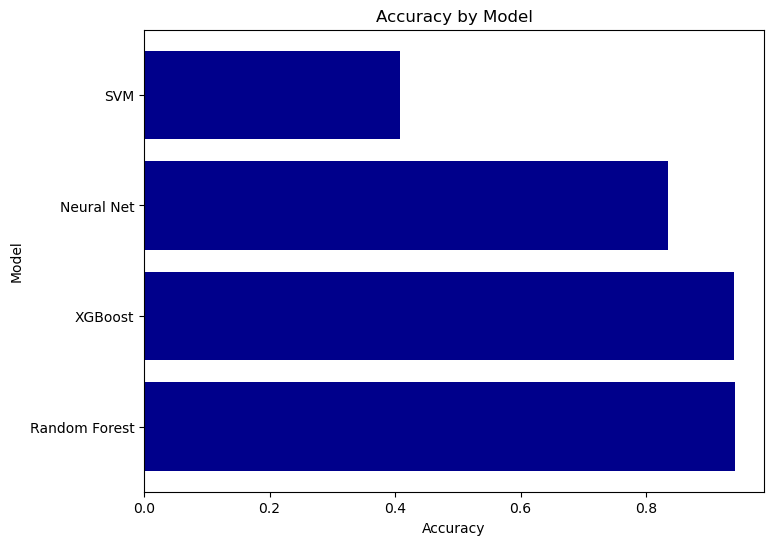

In [3]:
# Accuracy plot
models = ['Random Forest', 'XGBoost', 'Neural Net', 'SVM']
accuracies = [0.9407, 0.9395, 0.8343, 0.4071]
# baseline = 0.9336

plt.figure(figsize=(8, 6))
plt.barh(models, accuracies, color='darkblue')
# plt.axvline(x=baseline, color='red', linestyle='--', label=f'Baseline = {baseline}')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Accuracy by Model')
# plt.legend()
plt.show()

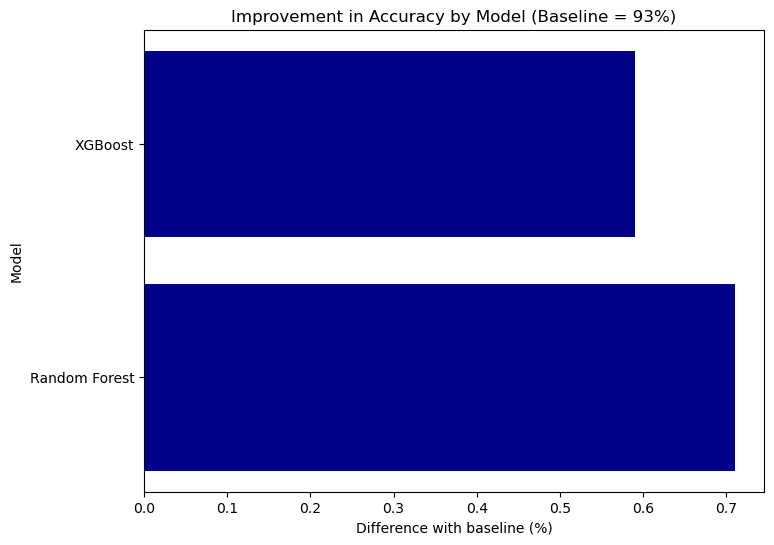

In [4]:
# Improvement in Accuracy plot
models = ['Random Forest', 'XGBoost']
accuracies = [(0.9407-0.9336)*100, (0.9395-0.9336)*100]
# baseline = 0.9336

plt.figure(figsize=(8, 6))
plt.barh(models, accuracies, color='darkblue')
# plt.axvline(x=baseline, color='red', linestyle='--', label=f'Baseline = {baseline}')
plt.xlabel('Difference with baseline (%)')
plt.ylabel('Model')
plt.title('Improvement in Accuracy by Model (Baseline = 93%)')
# plt.legend()
plt.show()